In [ ]:
import numpy as np
import random 
import math

In [ ]:
def fitness(x1, x2) : 
  return math.cos(math.radians(x1)) * math.sin(math.radians(x2)) - x1 / (x2**2 + 1)

class Individu() :

  def __init__(self, function) :
    x1=np.random.uniform(-1, 2)
    x2=np.random.uniform(-1, 1)

    self.function=function
    self.chromosome=np.array([x1, x2], dtype=np.float)
    self.fitness=function(self.chromosome[0], self.chromosome[1])

  def updateGen(self, x1, x2) : 
    self.chromosome = np.array([x1, x2], dtype=np.float)
    self.updateFitness() 

  def updateFitness(self) :
    self.fitness=self.function(self.chromosome[0], self.chromosome[1])
    
  def reset(self) : 
    x1=np.random.uniform(-1, 2)
    x2=np.random.uniform(-1, 1)

    self.chromosome=np.array([x1, x2], dtype=np.float)
    self.fitness=self.function(self.chromosome[0], self.chromosome[1])


class Population() : 

  def __init__(self, size, function) : 
    self.individu = self._initPopulation(size, function)
    self.fittest = self.getFittest()
    self.secondFittest = self.getSecondFittest() 
    self.leastFittest = self.getLeastFittest() 

  def _initPopulation(self, size, function) : 
    pop = []
    for i in range(size) : 
      individu = Individu(function)
      pop.append(individu)
    return np.array(pop)

  def updateFitness(self) : 
    for individu in self.individu : 
      individu.updateFitness()

  def getFittest(self) :
    max = self.individu[0] 
    for individu in self.individu :
      if individu.fitness > max.fitness : 
        max = individu 
    return max

  def getSecondFittest(self) : 
    max = self.individu[0] 
    for individu in self.individu : 
      if individu.fitness > max.fitness and not self.fittest : 
        max = individu 
    return max 

  def getLeastFittest(self) : 
    min = self.individu[0] 
    for individu in self.individu : 
      if individu.fitness < min.fitness : 
        min = individu 
    return min

  def updateState(self) : 
    self.updateFitness()
    self.fittest = self.getFittest()
    self.secondFittest = self.getSecondFittest() 
    self.leastFittest = self.getLeastFittest() 

class GADriver() : 
  def __init__(self, population, pc, pm, function) : 
    self.population = population
    self._pc = pc
    self._pm = pm
    self._funciton = function

  def config(self, pc, pm, function) : 
    self._pc = pc 
    self._pm = pm 
    self._function = function

  def crossover(self) : 
    
    rand = random.choices([0, 1], [(1 - self._pc), self._pc])
    if rand[0] == 1 : 
      x1 = self.population.fittest.chromosome[0]
      x2 = self.population.secondFittest.chromosome[1]
      self.population.leastFittest.updateGen(x1, x2)
  
  def mutation(self) :
    rand = random.choices([0, 1], [(1 - self._pm), self._pm])
    if rand[0] == 1 : 
      self.population.leastFittest.reset()


  def train(self, n_gen) :


    fit_history = []
    sec_history = []
    lea_history = []

    it = 1
    for i in range(n_gen) :

      fittest = self.population.fittest.fitness 
      fit_history.append(self.population.fittest.fitness)
      sec_history.append(self.population.secondFittest.fitness)
      lea_history.append(self.population.leastFittest.fitness)

      print("gen-{}".format(it))
      print("-"*10)
      print("Fittest : ", self.population.fittest.chromosome, self.population.fittest.fitness)
      print("Second  : ", self.population.secondFittest.chromosome, self.population.secondFittest.fitness)
      print("Least   : ", self.population.leastFittest.chromosome, self.population.leastFittest.fitness)
      print("\n")



      self.crossover()
      self.mutation()
      self.population.updateState()

      it+=1 

    return fit_history, sec_history, lea_history


In [ ]:
population = Population(20, fitness)
driver = GADriver(population, pc=0.9, pm=0.01, function=fitness)
driver.population.secondFittest.chromosome

array([ 1.34621704, -0.41509937])

In [ ]:
f_history, s_history, l_history = driver.train(n_gen=10000)

In [ ]:
print("Fittest : ", driver.population.fittest.chromosome, driver.population.fittest.fitness)
print("Second  : ", driver.population.secondFittest.chromosome, driver.population.secondFittest.fitness)
print("Least   : ", driver.population.leastFittest.chromosome, driver.population.leastFittest.fitness)

Fittest :  [-0.84381276 -0.01144034] 0.8435026871159558
Second  :  [-0.84381276 -0.12868595] 0.8278210470716054
Least   :  [-0.84381276 -0.12868595] 0.8278210470716054


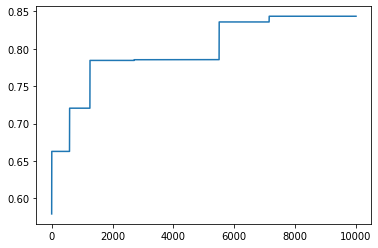

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(f_history)

In [ ]:
print("Fittest : ", driver.population.fittest.chromosome, driver.population.fittest.fitness)
print("Second  : ", driver.population.secondFittest.chromosome, driver.population.secondFittest.fitness)
print("Least   : ", driver.population.leastFittest.chromosome, driver.population.leastFittest.fitness)

Fittest :  [-0.59149721  0.09756889] 0.587622250806517
Second  :  [-0.59149721 -0.79220373] 0.34959439222499517
Least   :  [-0.59149721 -0.79220373] 0.34959439222499517


In [ ]:
  newlist = sorted(ut, key=lambda x: x.count, reverse=True)


NameError: ignored

In [ ]:
random_number = random.choices([0, 1], [0.9, 0.1])
random_number[0]


0

In [ ]:
test = np.array(['helol', 1, 3])

In [ ]:
haha = np.delete(test, [3], obj=1)

TypeError: ignored

In [ ]:
haha

array(['helol', '1', '3'], dtype='<U5')